**Background**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.


**Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**Attributes:**

* age : age of customer (numeric)
* job : type of job (categorical)
* marital : marital status (categorical)
* education (categorical)
* default: has credit in default? (binary)
* balance: average yearly balance, in euros (numeric)
* housing: has a housing loan? (binary)
* loan: has personal loan? (binary)
* contact: contact communication type (categorical)
* day: last contact day of the month (numeric)
* month: last contact month of year (categorical)
* duration: last contact duration, in seconds (numeric)
* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

* y - has the client subscribed to a term deposit? (binary)

**Goal(s):**

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

**Success Metric(s):**

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

**Bonus(es):**

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.
What makes the customers buy? Tell us which feature we should be focusing more on.

**Data Loading and Exploration:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import model_selection, feature_selection, metrics
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
# load the dataset
df = pd.read_csv('term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.000000,40000,40000,40000,40000,40000.000000,40000,40000,40000,40000.000000,40000,40000.000000,40000.000000,40000
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,11,NaN,NaN,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,no
freq,NaN,9383,24386,20993,39191,NaN,24031,33070,24914,NaN,13532,NaN,NaN,37104
mean,40.544600,NaN,NaN,NaN,NaN,1274.277550,NaN,NaN,NaN,16.017225,NaN,254.824300,2.882175,NaN
std,9.641776,NaN,NaN,NaN,NaN,2903.769716,NaN,NaN,NaN,8.278127,NaN,259.366498,3.239051,NaN
min,19.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,NaN
25%,33.000000,NaN,NaN,NaN,NaN,54.000000,NaN,NaN,NaN,8.000000,NaN,100.000000,1.000000,NaN
50%,39.000000,NaN,NaN,NaN,NaN,407.000000,NaN,NaN,NaN,17.000000,NaN,175.000000,2.000000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1319.000000,NaN,NaN,NaN,21.000000,NaN,313.000000,3.000000,NaN


**Observations**

* we have 40000 entries , 13 features and y column which is our target(yes/no indicating whether or not the customer has subscribed to a loan)
* We don't have any null values
* We also have 5 numerical features and 8 categorical features

In [5]:
# check the validity of string values
stringdata = df.select_dtypes(include="object")
for column in stringdata:
    print(stringdata[column].value_counts())
    print ("-" * 20)

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64
--------------------
married     24386
single      10889
divorced     4725
Name: marital, dtype: int64
--------------------
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64
--------------------
no     39191
yes      809
Name: default, dtype: int64
--------------------
yes    24031
no     15969
Name: housing, dtype: int64
--------------------
no     33070
yes     6930
Name: loan, dtype: int64
--------------------
cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64
--------------------
may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec

Job, education and contact features have some unkown values, we need to find a way to fill them


*  We can try some imputation techniques with unkown values: mean, median, mode
* LEt try first to fill with the most frequent value

In [6]:
#df = df[df['job'] != 'unknown']


df['job'].replace("unknown", df['job'].mode()[0], inplace = True)
df['education'].replace("unknown", df['education'].mode()[0], inplace = True)
df['contact'].replace("unknown", df['contact'].mode()[0], inplace = True)

In [7]:
# change label to 0/1
data = df.copy(deep=True)
data['y'].replace('no',0, inplace=True)
data['y'].replace('yes',1, inplace=True)
data

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,0
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,0
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,0
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,0
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,1
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,1
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,0


In [8]:
# transform continue data to categorical by grouping
intdata = df.select_dtypes(include="int64")
for column in intdata:
    df[column + "_bin"] = pd.cut(df[column], 8)
    df.drop(column, axis = 1, inplace = True)


# Using Label Encoding for categorical data   
label = LabelEncoder()
data_calc = pd.DataFrame()
for column in data:
    data_calc[column] = label.fit_transform(data[column])
    
data_calc


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,39,4,1,2,0,3023,1,0,0,4,8,261,0,0
1,25,9,2,1,0,945,1,0,0,4,8,151,0,0
2,14,2,1,1,0,918,1,1,0,4,8,76,0,0
3,28,1,1,1,0,2420,1,0,0,4,8,92,0,0
4,14,1,2,1,0,917,0,0,0,4,8,198,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,34,9,1,2,0,1311,0,0,0,2,6,107,0,0
39996,11,4,2,2,0,4035,0,0,0,2,6,238,2,1
39997,35,0,0,1,0,1116,0,0,0,2,6,170,0,1
39998,15,4,1,2,0,1963,0,0,0,2,6,342,0,0


In [9]:
# Putting feature variable to X
X = data_calc.drop(['y'], axis=1)

# puttting target variable to y
y = data_calc['y']

**Data Analysis**

/home/amath/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amath/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/amath/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` 

Text(0.5, 1.0, 'Duration of Time Contact Distribution by Subscription')

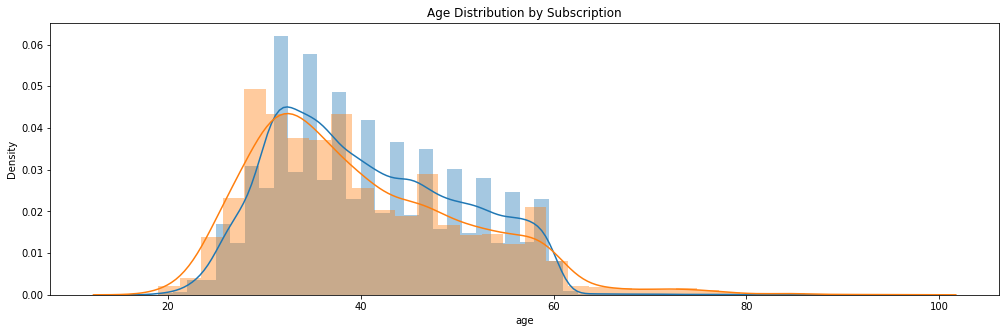

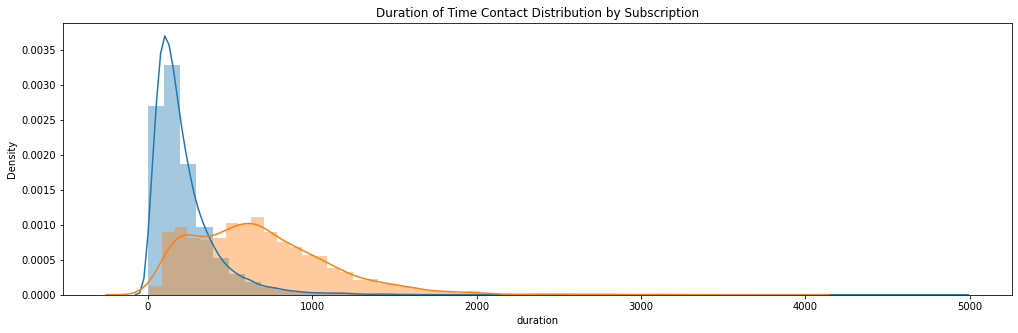

In [10]:
plt.figure(figsize = (17, 5))
sns.distplot(data.loc[data.y == 0, 'age'], label = "Not Subscribed", hist = True)
sns.distplot(data.loc[data.y == 1, 'age'], label = "Subscribed", hist = True)
plt.title("Age Distribution by Subscription")

plt.figure(figsize = (17, 5))
sns.distplot(data.loc[data.y == 0, 'duration'], label = "Not Subscribed", hist = True)
sns.distplot(data.loc[data.y == 1, 'duration'], label = "Subscribed", hist = True)
plt.title("Duration of Time Contact Distribution by Subscription")

**Observations:**

* customers between 20 and 60 years old are more wealling to subscribe term deposit.
* customers whose contact duration time is more than 500 agree to subrscibe term deposit.

Text(0.5, 1.0, 'Subscribe Probability by Education')

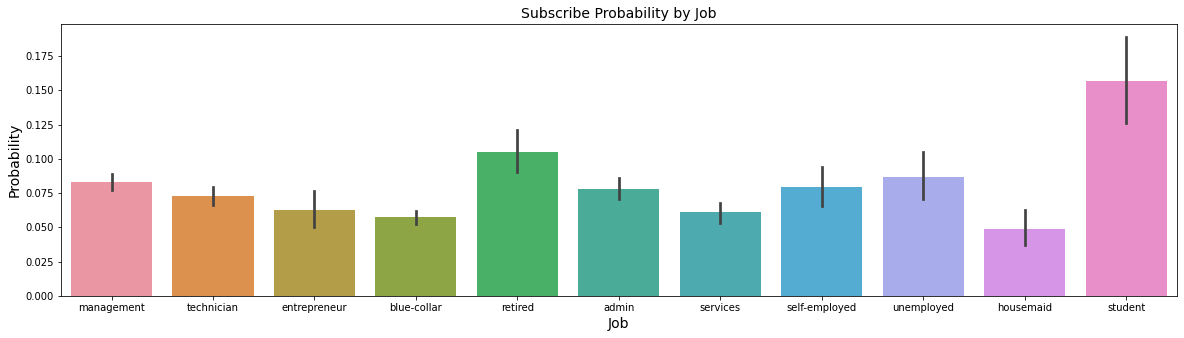

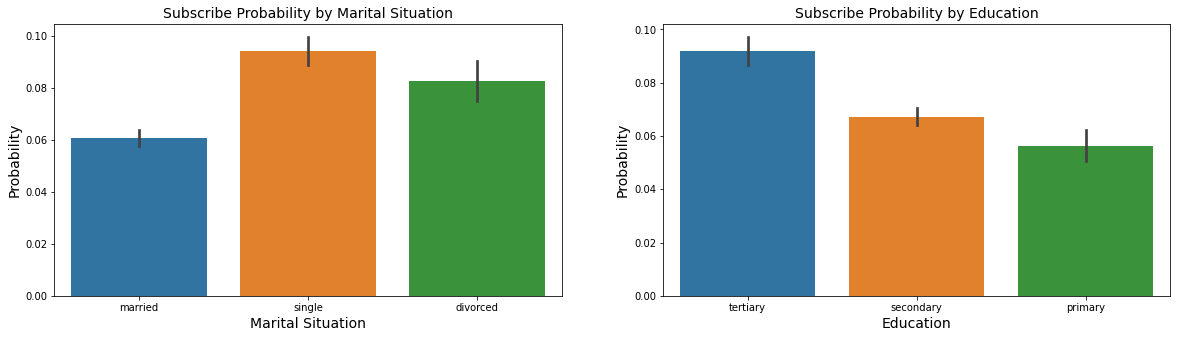

In [11]:
plt.figure( figsize = (20, 5))
sns.barplot(data = data, x = 'job', y = 'y')
plt.xlabel("Job", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Subscribe Probability by Job", fontsize = 14)

plt.figure( figsize = (20, 5))
plt.subplot(121)
sns.barplot(data = data, x = 'marital', y = 'y')
plt.xlabel("Marital Situation", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Subscribe Probability by Marital Situation", fontsize = 14)

plt.subplot(122)
sns.barplot(data = data, x = 'education', y = 'y')
plt.xlabel("Education", fontsize = 14)
plt.ylabel("Probability", fontsize = 14)
plt.title("Subscribe Probability by Education", fontsize = 14)

We observe that students, single and tertiary people are more wealling to subscribe term deposit

Text(0.5, 1.0, 'Age Distribution by Job, Divided by Subscription (0) for Not Subscribed, (1) for Subscribed')

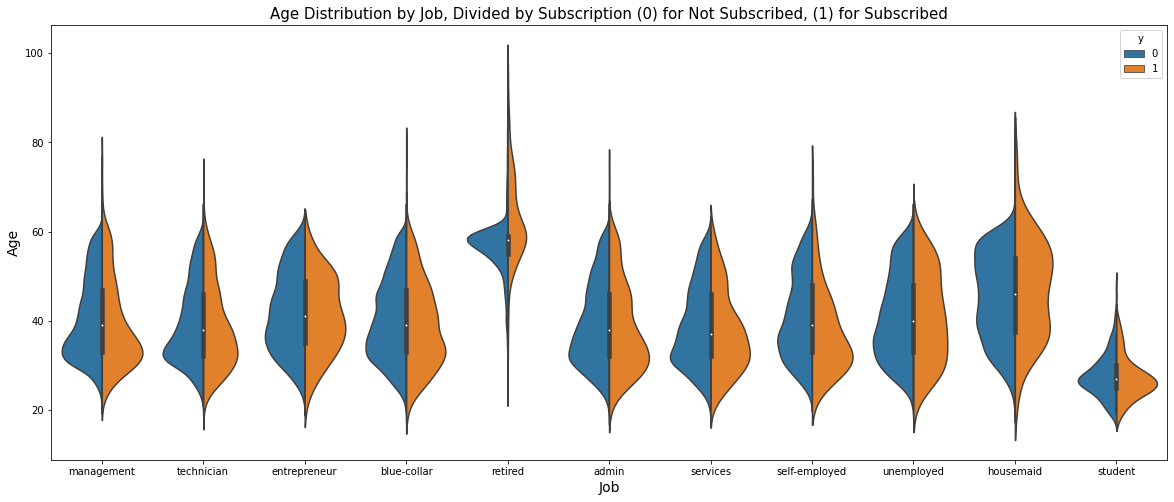

In [12]:
plt.figure( figsize = (20, 8))
sns.violinplot(x = 'job', y = 'age', hue = 'y', data = data, split = True)
plt.xlabel("Job", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.title("Age Distribution by Job, Divided by Subscription (0) for Not Subscribed, (1) for Subscribed", fontsize = 15)

For every job category, older people tend to accept term deposit subscription

Text(0.5, 1.0, 'Age Distribution by Personal Loan')

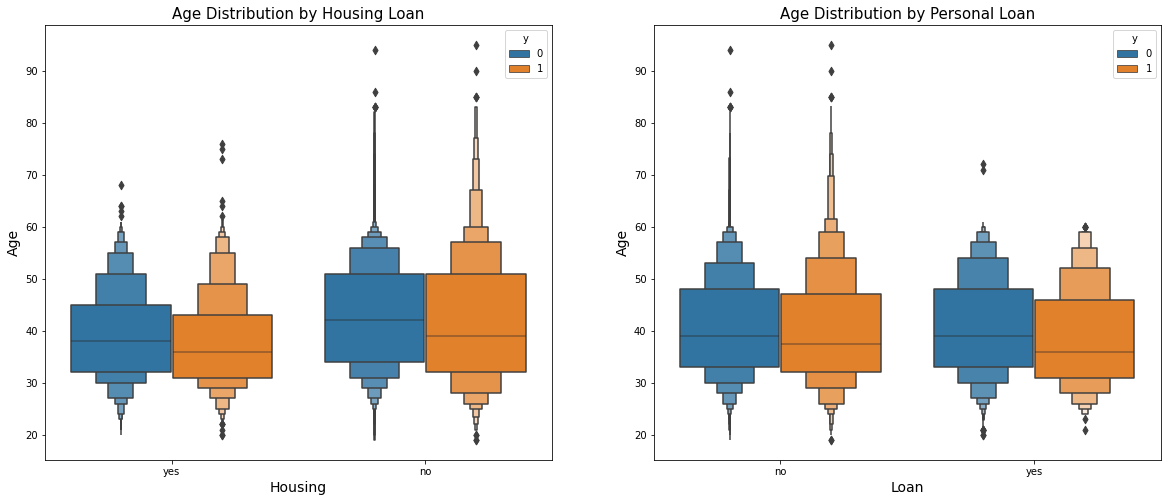

In [13]:
plt.figure( figsize = (20, 8))

plt.subplot(121)
sns.boxenplot(x = 'housing', y = 'age', hue = 'y', data = data)
plt.xlabel("Housing", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.title("Age Distribution by Housing Loan", fontsize = 15)

plt.subplot(122)
sns.boxenplot(x = 'loan', y = 'age', hue = 'y', data = data)
plt.xlabel("Loan", fontsize = 14)
plt.ylabel("Age", fontsize = 14)
plt.title("Age Distribution by Personal Loan", fontsize = 15)

* duration is more correlated to target variable
* campaign is less correlated

0    37104
1     2896
Name: y, dtype: int64


<AxesSubplot:xlabel='y', ylabel='count'>

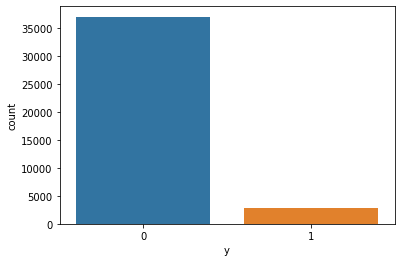

In [14]:
print(data_calc['y'].value_counts())
sns.countplot(x='y', data=data_calc)

We observe that the data is highly unbalanced

In [15]:
#oversampling from the minority class
#from imblearn.over_sampling import RandomOverSampler
#ROS = RandomOverSampler(sampling_strategy='minority', random_state=42)

#X, y = ROS.fit_resample(X, y)

**Model Training**

In [16]:
#Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75,test_size = 0.25, random_state = 42,stratify=y)

In [17]:
#oversampling from the minority class
from imblearn.over_sampling import RandomOverSampler
ROS = RandomOverSampler(sampling_strategy='minority', random_state=42)

X_train, y_train = ROS.fit_resample(X_train, y_train)

In [18]:
def model_performance(Xlr,ylr):
    # Spot Check Algorithms
    SEED=42
    models = []
    models.append(('LR', LogisticRegression(C=9,max_iter=3000,solver="lbfgs")))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DesTree', DecisionTreeClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC(gamma='auto',probability=True)))
    models.append(('RF', RandomForestClassifier(n_jobs=-1, n_estimators=100,random_state=SEED, class_weight="balanced_subsample")))
    ratio = float(np.sum(ylr == 0)) / np.sum(ylr==1)
    models.append(('XGB', XGBClassifier(scale_pos_weight = ratio, learning_rate =0.001,
                        objective= 'binary:logistic', use_label_encoder=True, eval_metric='error')))

    # evaluate each model in turn
    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        #kfold = KFold(n_splits=5, random_state=0, shuffle=True)
        cv_results = cross_val_score(model, Xlr, ylr, cv=kfold, scoring='accuracy')
        results.append(cv_results)
        names.append(name)
        print('%s: %.2f (%.2f)' % (name, cv_results.mean()*100, cv_results.std()))
    _ = plt.bar(names,np.mean(results, axis=1)*100)

LR: 81.13 (0.00)
LDA: 79.84 (0.00)
KNN: 93.19 (0.00)
DesTree: 93.03 (0.00)
NB: 80.80 (0.00)
SVM: 100.00 (0.00)
RF: 98.15 (0.00)
[13:34:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:09] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:10] WARNING: /workspace/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language 

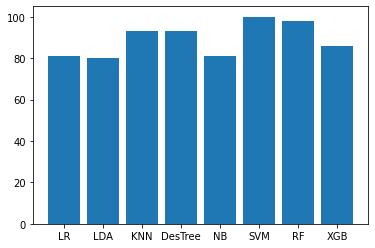

In [19]:
# model performance and average performance score
model_performance(X_train, y_train)

**Performance Logistic Regression: LR**

In [20]:
rfcModel = LogisticRegression(C=9,max_iter=3000,solver="lbfgs")
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score1 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score1)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.8952837358453706
Testing Accuracy: 84.33 

Confusion matrix:
[[7863 1413]
 [ 154  570]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      9276
           1       0.29      0.79      0.42       724

    accuracy                           0.84     10000
   macro avg       0.63      0.82      0.67     10000
weighted avg       0.93      0.84      0.87     10000



**Linear Discriminant Analysis**

In [21]:
rfcModel = LinearDiscriminantAnalysis()
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr2, tpr2, thresh2 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score2 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score2)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.8953757573158558
Testing Accuracy: 87.26 

Confusion matrix:
[[8194 1082]
 [ 192  532]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      9276
           1       0.33      0.73      0.46       724

    accuracy                           0.87     10000
   macro avg       0.65      0.81      0.69     10000
weighted avg       0.93      0.87      0.89     10000



**K Nearest Neighbor:**

In [22]:
rfcModel = KNeighborsClassifier()
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr3, tpr3, thresh3 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score3 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score3)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.760552763145669
Testing Accuracy: 85.63 

Confusion matrix:
[[8162 1114]
 [ 323  401]]

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      9276
           1       0.26      0.55      0.36       724

    accuracy                           0.86     10000
   macro avg       0.61      0.72      0.64     10000
weighted avg       0.91      0.86      0.88     10000



**Decision Tree Classifier**

In [29]:
rfcModel = DecisionTreeClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=10, min_samples_split=10,
                       random_state=42)
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr4, tpr4, thresh4 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score4 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score4)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.8126720563254786
Testing Accuracy: 88.68 

Confusion matrix:
[[8372  904]
 [ 228  496]]

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      9276
           1       0.35      0.69      0.47       724

    accuracy                           0.89     10000
   macro avg       0.66      0.79      0.70     10000
weighted avg       0.93      0.89      0.90     10000



**Gaussian Naive Bayes**

In [25]:
rfcModel = GaussianNB()
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr5, tpr5, thresh5 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score5 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score5)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.8863658428213723
Testing Accuracy: 85.35 

Confusion matrix:
[[7985 1291]
 [ 174  550]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.86      0.92      9276
           1       0.30      0.76      0.43       724

    accuracy                           0.85     10000
   macro avg       0.64      0.81      0.67     10000
weighted avg       0.93      0.85      0.88     10000



**Super Vector Machine**

In [41]:
rfcModel = SVC(gamma='auto')
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test, probability=True)
# roc curve for models
fpr6, tpr6, thresh6 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score6 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score6)

print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

Testing Accuracy: 92.75 

Confusion matrix:
[[9275    1]
 [ 724    0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9276
           1       0.00      0.00      0.00       724

    accuracy                           0.93     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.86      0.93      0.89     10000



**XGBoost Classifier**

In [ ]:
ratio = float(np.sum(y_train == 0)) / np.sum(y_train==1)
rfcModel = XGBClassifier(scale_pos_weight = ratio, learning_rate =0.01,
                        objective= 'binary:logistic', use_label_encoder=False, eval_metric='error')
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr7, tpr7, thresh7 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score7 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score7)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

AUC score: 0.9121988604823473
Testing Accuracy: 87.16 

Confusion matrix:
[[8116 1160]
 [ 124  600]]

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.87      0.93      9276
           1       0.34      0.83      0.48       724

    accuracy                           0.87     10000
   macro avg       0.66      0.85      0.70     10000
weighted avg       0.94      0.87      0.89     10000



**Random Forest Classifier**

In [ ]:
rfcModel = RandomForestClassifier(n_jobs=-1, n_estimators=100,random_state=42, class_weight="balanced_subsample")
rfcModel.fit(X_train, y_train)
predictions = rfcModel.predict(X_test)
predictions_proba = rfcModel.predict_proba(X_test)
# roc curve for models
fpr8, tpr8, thresh8 = roc_curve(y_test, predictions_proba[:,1], pos_label=1)

# Evaluate predictions
auc_score8 = roc_auc_score(y_test, predictions_proba[:,1])
print("AUC score:",auc_score8)
print('Testing Accuracy: %.2f \n' % (accuracy_score(y_test, predictions)*100))
print('Confusion matrix:')
print(confusion_matrix(y_test, predictions))
print('\nClassification Report:\n')
print(classification_report(y_test, predictions))

#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, rfcModel.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)



plt.show()

AUC score: 0.9290392362873118
Testing Accuracy: 93.24 

Confusion matrix:
[[9017  259]
 [ 417  307]]

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9276
           1       0.54      0.42      0.48       724

    accuracy                           0.93     10000
   macro avg       0.75      0.70      0.72     10000
weighted avg       0.93      0.93      0.93     10000



Text(0.5, 1.0, 'Feature importances')

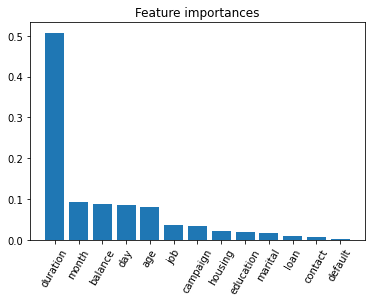

In [ ]:
#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=60)
plt.title('Feature importances')

Conclusion:
* SVM is performing extremelly good, with good precision, recall and F1 score. Hope the model is not overfitting
* The data is highly unbalanced, i observe that if we apply oversampling technique on the initial data before splitting, we will run to overfitting.
* In fact, the right way is to apply oversampling on training data. 
* We use also features importance teechnique and realize that duration is highly used, month, balance, day and age are also slighly important.
*During the next survey, i will suggest to focus more on features bellow duration, month, balance, day and age.

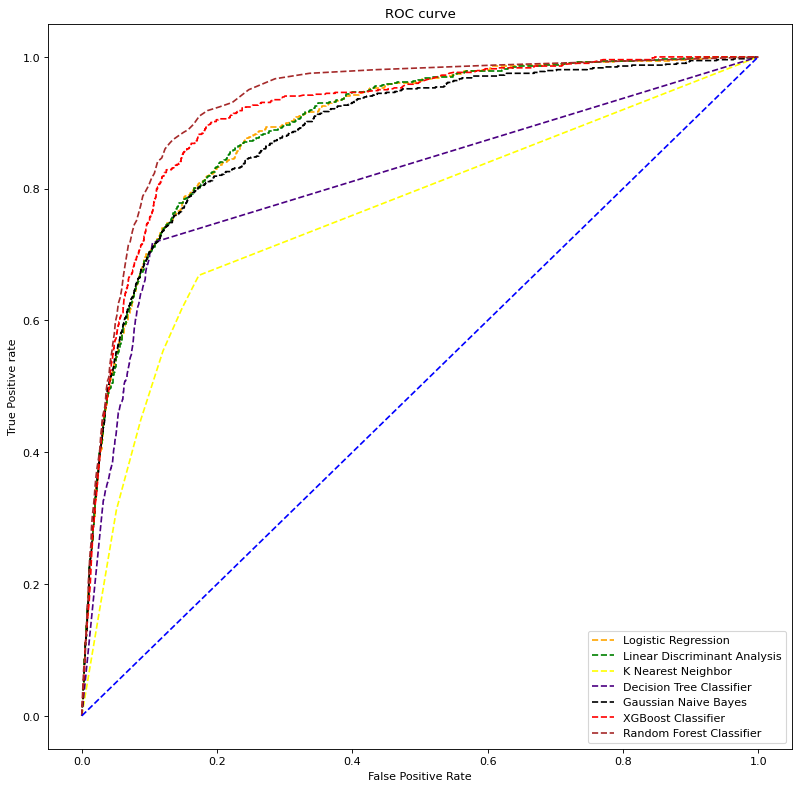

In [ ]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(fpr2, tpr2, linestyle='--',color='green', label='Linear Discriminant Analysis')
plt.plot(fpr3, tpr3, linestyle='--',color='yellow', label='K Nearest Neighbor')
plt.plot(fpr4, tpr4, linestyle='--',color='indigo', label='Decision Tree Classifier')
plt.plot(fpr5, tpr5, linestyle='--',color='black', label='Gaussian Naive Bayes')
plt.plot(fpr6, tpr6, linestyle='--',color='grey', label='Super Vector Machine')
plt.plot(fpr7, tpr7, linestyle='--',color='red', label='XGBoost Classifier')
plt.plot(fpr8, tpr8, linestyle='--',color='brown', label='Random Forest Classifier')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();